In [41]:
%pip install pylatex pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd

df = pd.read_csv("measurements/reliable-results.csv")
df

,content_type,number_of_peers,opt_type,runtime_in_ms,success,objective,avg_delay
0,VIDEO,2,DIR,0.2387,1,128.0,45.8707
1,VIDEO,2,HEU,2.7246,1,128.0,45.8707
2,VIDEO,2,ILP,872.8333,1,128.0,45.8707
3,VIDEO,2,MST,12.6646,1,128.0,45.8707
4,VIDEO,8,DIR,0.0160,1,1145.0,54.3554
...,...,...,...,...,...,...,...
440,MESSAGING,37,HEU,45.0265,1,659.0,83.1730
441,MESSAGING,37,MST,13.1075,1,650.0,88.7611
442,MESSAGING,43,DIR,0.0598,1,8105.0,57.3500
443,MESSAGING,43,HEU,52.7501,1,658.0,85.2511


In [43]:
MAX_PEERS = 24

opt_data_by_content = {}

# Gather data for plotting
for content_type in df["content_type"].unique():
    data = df[(df["content_type"] == content_type) & (df["number_of_peers"] <= MAX_PEERS)].sort_values(["number_of_peers"])
    print(f"Content type: {content_type}:\n{data.describe()}")

    peers = data["number_of_peers"].unique()
    dir_data = data[data["opt_type"] == "DIR"]
    heu_data = data[data["opt_type"] == "HEU"]
    ilp_data = data[data["opt_type"] == "ILP"]
    mst_data = data[data["opt_type"] == "MST"]

    # Adjust zero values in dir_data to 0.1 to avoid log(0)
    dir_data.loc[dir_data["runtime_in_ms"] <= 0.1, "runtime_in_ms"] = 0.1

    # Put data together for plotting
    opt_data = {"DIR": dir_data, "HEU": heu_data, "ILP": ilp_data, "MST": mst_data}
    opt_data_by_content[content_type] = opt_data

print("Data for plotting:")
for content_type, opt_data in opt_data_by_content.items():
    print(content_type)
    for opt_type, data in opt_data.items():
        print(f"\t{opt_type}: #{len(data)}")

Content type: VIDEO:
       number_of_peers  runtime_in_ms  success    objective  avg_delay
count        83.000000   8.300000e+01     83.0    83.000000  83.000000
mean         12.240964   1.552348e+05      1.0   976.722892  67.083886
std           6.532452   5.622661e+05      0.0  1072.966282  12.517172
min           2.000000   1.570000e-02      1.0   128.000000  45.870700
25%           7.000000   2.335500e-01      1.0   384.500000  57.891900
50%          12.000000   1.177380e+01      1.0   636.000000  65.344300
75%          17.500000   1.648435e+01      1.0   652.000000  76.881650
max          24.000000   3.384428e+06      1.0  4677.000000  94.663900
Content type: AUDIO:
       number_of_peers  runtime_in_ms  success    objective  avg_delay
count        82.000000   8.200000e+01     82.0    82.000000  82.000000
mean         12.207317   1.228210e+05      1.0   980.902439  66.866970
std           6.565412   4.676695e+05      0.0  1078.889228  12.393694
min           2.000000   1.340000e-

In [66]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

NAMES = {
    "DIR": "Direct Link Tree",
    "HEU": "Multicast Heuristic",
    "ILP": "Integer Linear Programming",
    "MST": "Minimum Spanning Tree",
}

LATENCIES = {
    "VIDEO": 400,
    "AUDIO": 150,
    "MESSAGING": 1000,
    # "GAMING": 50,
}

def plot_runtime_vs_peers(opt_data_by_content):
    COLORED_MARKERS = [("black", "o"), ("blue", "p"), ("red", "s"), ("green", "^")]

    col_count = 3
    row_count = (len(opt_data_by_content) + col_count - 1) // col_count

    # Create the figure and grid specification
    fig = plt.figure(figsize=(6 * col_count, 3 * 5.5 * row_count))
    gs = GridSpec(3 * row_count, col_count, width_ratios=[1] * col_count, figure=fig, wspace=0.25, hspace=0.1)

    for i, (content_type, opt_data) in enumerate(sorted(opt_data_by_content.items(), key=lambda x: LATENCIES[x[0]], reverse=True)):
        peers = range(1, len(opt_data["DIR"]) + 1)

        # Logarithmic scale subplot
        ax = fig.add_subplot(gs[0, i])
        ax.set_title(f"D = {LATENCIES[content_type]} ms")
        ax.set_yscale("log")
        # ax.set_xlabel("Number of Peers")
        ax.set_ylabel("Runtime [ms]")
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)
        ax.set_ylim([0.1, 1e7])
        ax.set_xticks(peers)
        ax.xaxis.set_major_locator(plt.MaxNLocator(nbins="auto", integer=True))

        # Linear scale subplot for the objective value
        ax2 = fig.add_subplot(gs[1, i])
        # ax2.set_title(f"D = {LATENCIES[content_type]} ms")
        ax2.set_yscale("linear")
        # ax2.set_xlabel("Number of Peers")
        ax2.set_ylabel("Objective [unit]")
        ax2.grid(True, which="both", linestyle="--", linewidth=0.4)
        ax2.set_ylim([0, 10000])
        ax2.set_xticks(peers)
        ax2.xaxis.set_major_locator(plt.MaxNLocator(nbins="auto", integer=True))

        # Linear scale subplot for the delay value
        ax3 = fig.add_subplot(gs[2, i])
        # ax3.set_title(f"D = {LATENCIES[content_type]} ms")
        ax3.set_yscale("linear")
        ax3.set_xlabel("Number of Peers")
        ax3.set_ylabel("Average E2E delay [ms]")
        ax3.grid(True, which="both", linestyle="--", linewidth=0.4)
        ax3.set_ylim([0, LATENCIES[content_type] * 1.1])
        ax3.set_xticks(peers)
        ax3.xaxis.set_major_locator(plt.MaxNLocator(nbins="auto", integer=True))

        for (opt, data), (color, marker) in zip(opt_data.items(), COLORED_MARKERS):
            opt_name = NAMES[opt]
            count = min(len(data), len(peers))
            ax.plot(peers[:count], data["runtime_in_ms"].values[:count], label=opt_name, color=color, marker=marker, linewidth=1.5)
            ax2.plot(peers[:count], data["objective"].values[:count], label=opt_name, color=color, marker=marker, linewidth=1.5)
            ax3.plot(peers[:count], data["avg_delay"].values[:count], label=opt_name, color=color, marker=marker, linewidth=1.5)

    # Labels from the last subplot
    handles, labels = ax.get_legend_handles_labels()
    # set minimal padding for the legend
    fig.legend(handles, labels, ncol=len(labels), loc="upper center", bbox_to_anchor=(0.5, 0.925), borderaxespad=0.01)

    # Show the plot
    plt.rcParams["svg.fonttype"] = "none"
    plt.savefig("runtime_vs_peers.svg", bbox_inches="tight", pad_inches=0.1)

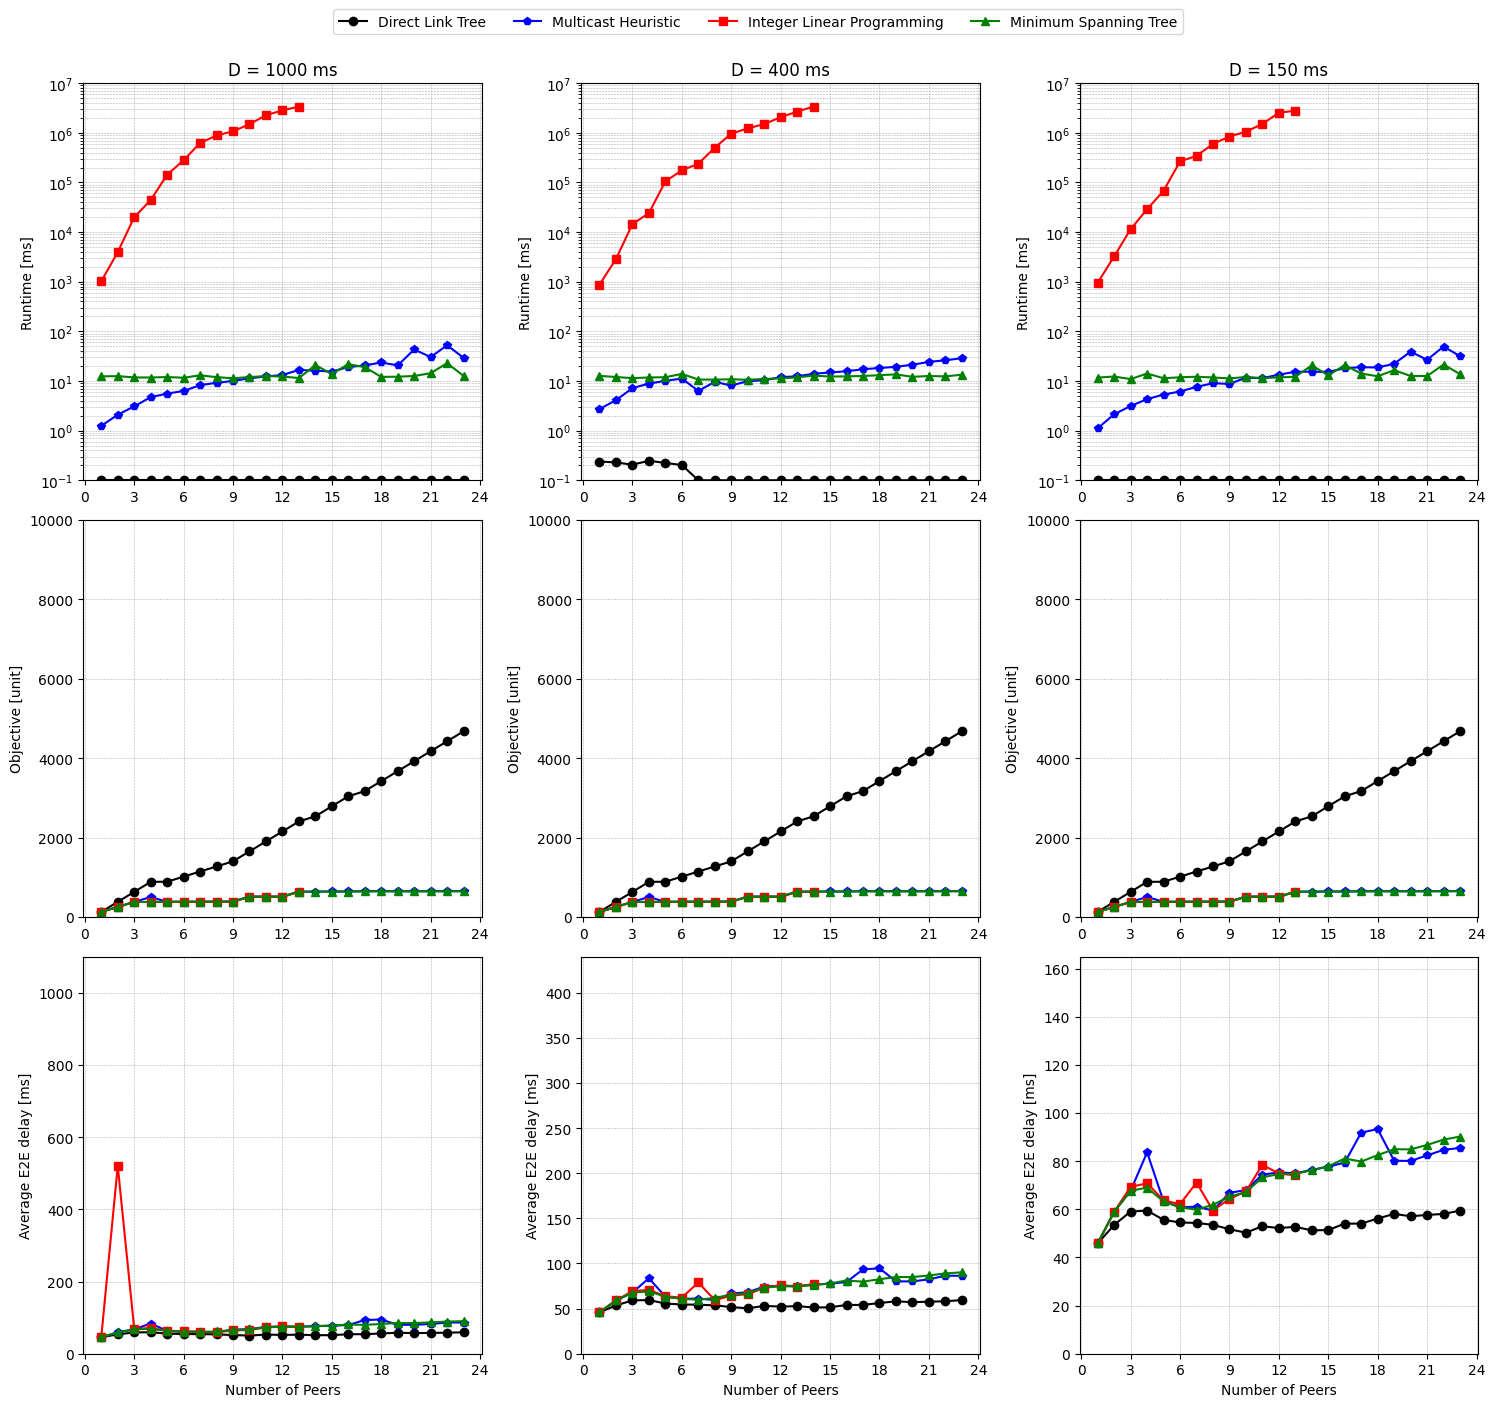

In [67]:
plot_runtime_vs_peers(opt_data_by_content)